# __Model Building and Evaluation__

### Phase 3 Project - Chicago Traffic Crash Classification

#### Author: Ian Sharff

> The objective of this project is to develop an effective, multi-class classification model for the Chicago Traffic Crashes Dataset available from the <a href="https://data.cityofchicago.org/Transportation/Traffic-Crashes-Crashes/85ca-t3if">Chicago Data Portal</a>. This dataset is vast in size, containing detailed information on roughly 500,000 traffic crashes since 2015 when the dataset was first created. In particular, this study is concerned with predicting the primary contributory causes of these various accidents. A highly efficient model that could deduce the most salient cause of a car crash could be helpful for crash report formulation. In addition, it could be used to distinguish the factors that are widespread among all crashes as well as those that are particular to crashes arising from given circumstances.

## **Business Understanding**

This study is framed from the point of view of the governmental agencies of the city of Chicago, namely those behind the <a href="https://www.chicago.gov/city/en/depts/cdot/supp_info/vision-zero-chicago.html">Vision Zero Chicago</a> initiative, which is dedicated to reducing (or ideally, eliminating) fatal and incapacitating injuries arising from tragic, and largely avoidable traffic accidents. The purpose of this project is, thus, to provide the city of Chicago with valuable insight regarding the most causatory factors of fatal and non-fatal traffic crashes, as well as a predictive model that can be used in cases where an officer is not available to make a judgement regarding the most likely primary cause. In a perfect world, every car crash would easily be assigned a primary cause with sound judgement from those who report them. However, this dataset makes it abundantly clear that the realm of automobile accidents is far from perfect. A sizeable portion of the data does not contain a primary cause associated with a given crash. This could be due to a variety of reasons, one being a lack of eyewitness testimony. A classification model that could hypothesize a general primary cause could help to fill in the gaps of the data and create a more holisitc view of the problem at hand.

## **Data Understanding and Preparation**

The original dataset contains roughly 500,000 rows, each pertaining to a given car crash since 2015. While other datasets for the vehicles and people involed exist, given the time frame of the project these were excluded from the current analysis, but can be incorporated at a later time. Imports used to manipulate the cleaned data are in the following cell, and the details of original processing are included in [trim_crashes.py](trim_crashes.py). Further information regarding data preparation can be found in the [README](README.md), and the groupings for the target, `PRIM_CONTRIBUTORY_CAUSE` can be found in [bin_causes.py](bin_causes.py). Furthermore, visualizations of the data and brief explanations can be found in the [visualizations notebook](03_visualizations.ipynb).

## **Model Building and Evaluation**

A total of four models were created for this project using the following imports. The `DummyClassifier` was used as baseline with a stratefied strategy due to the class imbalances present in the dataset. Two `DecisionTreeClassifier` models were designed, with and without using `SMOTE` to counteract said class imbalances. Finally, the best performing model was the `GradientBoostingClassifier` with `SMOTE`, which accounted for class imbalances more so than the other models while maintaining the high overall accuracy of the first decision tree model. However, given these imbalances, accuracy is not nearly as important as the F-1 score at determining model efficacy, and this was taken as the most significant metric. and it was clear that the issue likely lies with the underlying grouping of data and the lack of hyperparameter. Using the `ModelEvaluator` class to evaluate each model and the `TrainTestSplit` object (both defined in [models.py](models.py)), the process was streamlined to a certain degree.

In [1]:
# Data manipulation and model storage
import pandas as pd
import numpy as np
import pickle

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('images/presentation.mplstyle')

# Preprocessing and Pipelines
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_union

# Models using SMOTE
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Models employed
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

# Model validation and 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix

# Custom model evaluation and fitting classes
from models import ModelEvaluator, TrainTestSplit

Here, we define constants for the columns to be used in the models. While not directly used here, they are used to gather the feature names in order to determine the most important features of the model after one-hot encoding the categorical columns. 

In [2]:
# Can be altered to add/remove features
BIN_FIELDS = ['INTERSECTION_RELATED_I',
              'HIT_AND_RUN_I',
              'WORK_ZONE_I']
CAT_FIELDS = ['TRAFFIC_CONTROL_DEVICE',
              'DEVICE_CONDITION',
              'WEATHER_CONDITION',
              'LIGHTING_CONDITION',
              'FIRST_CRASH_TYPE',
              'TRAFFICWAY_TYPE',
              'ALIGNMENT',
              'ROADWAY_SURFACE_COND',
              'ROAD_DEFECT',
              'CRASH_TYPE',
              'DAMAGE',
              'MOST_SEVERE_INJURY',
              'CRASH_HOUR',
              'CRASH_DAY_OF_WEEK',
              'CRASH_MONTH',
              'CRASH_YEAR']
NUM_FIELDS = ['POSTED_SPEED_LIMIT',
              'NUM_UNITS',
              'INJURIES_TOTAL',
              'INJURIES_FATAL',]

with open('data/binned_causes.pkl', 'rb') as f:
    BINNED_CAUSES = pickle.load(f)


In [3]:
# Read crashes data from previously created PKL file
crashes = pd.read_pickle('data/crashes.pkl')
crashes.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300067 entries, 0 to 526552
Data columns (total 27 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   CRASH_RECORD_ID          300067 non-null  object 
 1   CRASH_YEAR               300067 non-null  int64  
 2   POSTED_SPEED_LIMIT       300067 non-null  int64  
 3   TRAFFIC_CONTROL_DEVICE   292808 non-null  object 
 4   DEVICE_CONDITION         286326 non-null  object 
 5   WEATHER_CONDITION        293434 non-null  object 
 6   LIGHTING_CONDITION       296512 non-null  object 
 7   FIRST_CRASH_TYPE         300067 non-null  object 
 8   TRAFFICWAY_TYPE          289966 non-null  object 
 9   ALIGNMENT                300067 non-null  object 
 10  ROADWAY_SURFACE_COND     287717 non-null  object 
 11  ROAD_DEFECT              261922 non-null  object 
 12  CRASH_TYPE               300067 non-null  object 
 13  INTERSECTION_RELATED_I   84862 non-null   object 
 14  HIT_

Here, we define a variable `splits` that simply contains train-test splits for the dataset in a `TrainTestSplit` instance. This was intended to simplify interaction with the `ModelEvaluator` object by encapsulating the train and test data within the class while also ensuring that data leakage is avoided. The default options for `TrainTestSplit` are `random_state=42` and `stratified=y`, simply wrapping the convenience function `train_test_split`.

In [4]:
X = crashes.drop('PRIM_CONTRIBUTORY_CAUSE', axis=1)
y = crashes['PRIM_CONTRIBUTORY_CAUSE'].map(BINNED_CAUSES)

splits = TrainTestSplit(X, y)

Here, we display the degree of class imbalance present in the data.

In [5]:
print(splits.y_train.value_counts(normalize=True, dropna=False))
print()
print(splits.y_test.value_counts(normalize=True, dropna=False))

DRIVER                0.868807
ENVIRONMENT           0.072397
DISREGARDING_SIGNS    0.058796
Name: PRIM_CONTRIBUTORY_CAUSE, dtype: float64

DRIVER                0.868803
ENVIRONMENT           0.072397
DISREGARDING_SIGNS    0.058800
Name: PRIM_CONTRIBUTORY_CAUSE, dtype: float64


## Baseline Model: Dummy Classifier

The dummy model here serves as a baseline, simply reflecting the class imbalance through taking a stratified approach. As you can see, the majority class scores very high compared to the very poor scores in the minority classes.

In [6]:
dummy = ModelEvaluator(
    splits,
    DummyClassifier(strategy='stratified'),
    'Dummy Classifier'
)

dummy.run_model()

Fitting Dummy Classifier...
Dummy Classifier fitted successfully
Predicting Target values...
Target values predicted successfully


In [7]:
dummy.train_test_classification_reports()

__________TRAIN SCORES__________
                    precision    recall  f1-score   support

DISREGARDING_SIGNS       0.06      0.06      0.06     13232
            DRIVER       0.87      0.87      0.87    195525
       ENVIRONMENT       0.07      0.07      0.07     16293

          accuracy                           0.76    225050
         macro avg       0.33      0.33      0.33    225050
      weighted avg       0.76      0.76      0.76    225050

------------------------------

__________TEST SCORES__________
                    precision    recall  f1-score   support

DISREGARDING_SIGNS       0.06      0.06      0.06      4411
            DRIVER       0.87      0.87      0.87     65175
       ENVIRONMENT       0.07      0.07      0.07      5431

          accuracy                           0.76     75017
         macro avg       0.33      0.33      0.33     75017
      weighted avg       0.76      0.76      0.76     75017

------------------------------



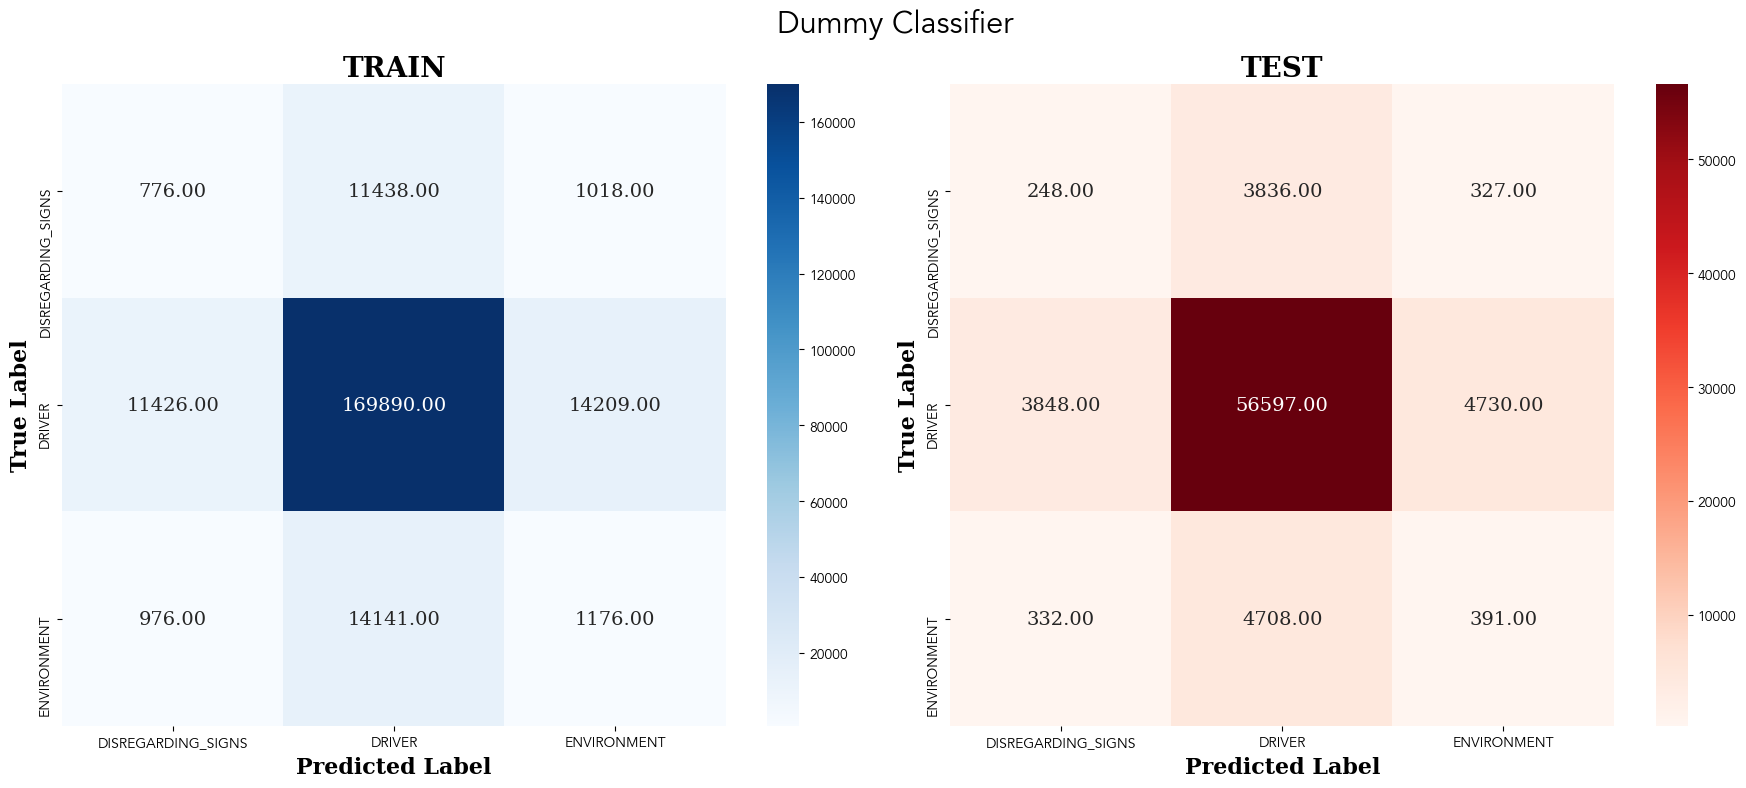

In [8]:
dummy.confusion_matrices()

## Decision Tree Classifier

The first real model was a basic decision tree with a low max_depth. This was kept simple for the purpose of avoiding computational complexity and runtime, but running on smaller samples to perform extensive grid searches and cross validations can be done in future iterations of this study.

In [9]:
with open('fitted_models/decisiontree_simple.pkl', 'rb') as f:
    decision_tree_fitted = pickle.load(f)

In [10]:
decision_tree = ModelEvaluator(
    splits,
    decision_tree_fitted,
    'Simple Decision Tree',
    fitted=True
)

# String representation of the ModelEvaluator object
print(decision_tree)

Simple Decision Tree: FITTED

Pipeline(steps=[('imputers',
                 ColumnTransformer(transformers=[('binary',
                                                  SimpleImputer(fill_value=False,
                                                                strategy='constant'),
                                                  ['INTERSECTION_RELATED_I',
                                                   'HIT_AND_RUN_I',
                                                   'WORK_ZONE_I']),
                                                 ('categorical',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['TRAFFIC_CONTROL_DEVICE',
                                                   'DEVICE_CONDITION',
                                                   'WEATHER_CONDITION',
                                                   'LIGHTING_CONDITION',
                                                   

In [11]:
# decision_tree.cross_val()
# decision_tree.display_cv_results()

In [12]:
decision_tree.train_test_classification_reports()

Predicting Target values...
Target values predicted successfully
__________TRAIN SCORES__________
                    precision    recall  f1-score   support

DISREGARDING_SIGNS       0.42      0.60      0.50     13232
            DRIVER       0.93      0.80      0.86    195525
       ENVIRONMENT       0.24      0.56      0.33     16293

          accuracy                           0.77    225050
         macro avg       0.53      0.65      0.56    225050
      weighted avg       0.85      0.77      0.80    225050

------------------------------

__________TEST SCORES__________
                    precision    recall  f1-score   support

DISREGARDING_SIGNS       0.43      0.61      0.50      4411
            DRIVER       0.94      0.80      0.86     65175
       ENVIRONMENT       0.24      0.56      0.33      5431

          accuracy                           0.77     75017
         macro avg       0.53      0.66      0.57     75017
      weighted avg       0.86      0.77      0.81    

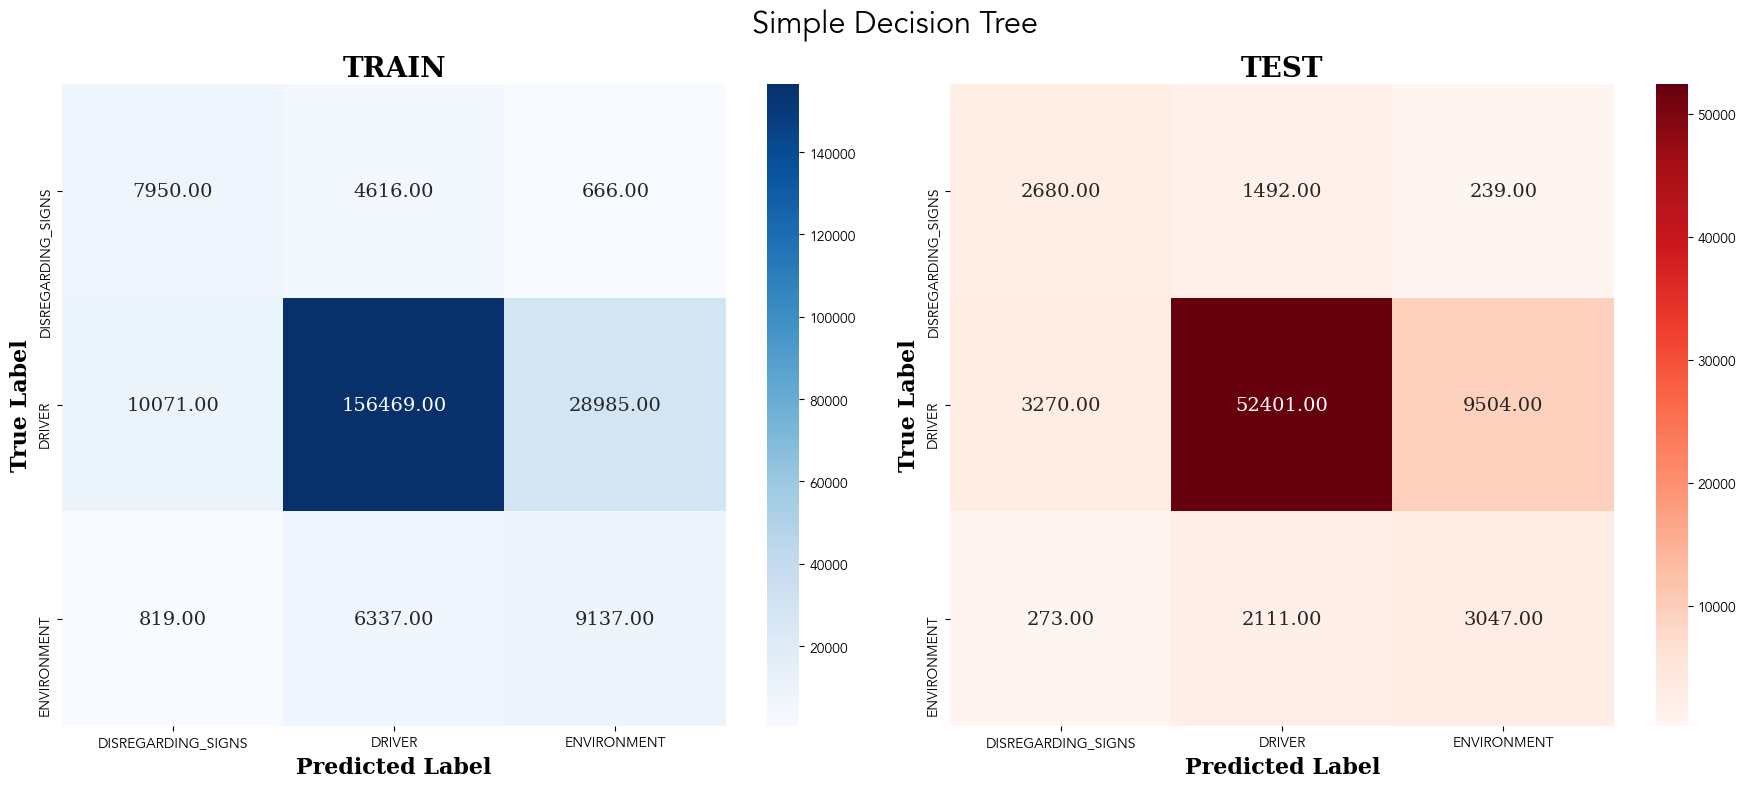

In [13]:
decision_tree.confusion_matrices()

## Simple Decision Tree Classifier with SMOTE

In [14]:
with open('fitted_models/decisiontree_simple.pkl', 'rb') as f:
    decision_tree_smote_fitted = pickle.load(f)

In [15]:
decision_tree_smote = ModelEvaluator(
    splits,
    decision_tree_smote_fitted,
    'SMOTE Decision Tree',
    fitted=True
)

print(decision_tree_smote)

SMOTE Decision Tree: FITTED

Pipeline(steps=[('imputers',
                 ColumnTransformer(transformers=[('binary',
                                                  SimpleImputer(fill_value=False,
                                                                strategy='constant'),
                                                  ['INTERSECTION_RELATED_I',
                                                   'HIT_AND_RUN_I',
                                                   'WORK_ZONE_I']),
                                                 ('categorical',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['TRAFFIC_CONTROL_DEVICE',
                                                   'DEVICE_CONDITION',
                                                   'WEATHER_CONDITION',
                                                   'LIGHTING_CONDITION',
                                                   '

In [16]:
# decision_tree_smote.cross_val()
# decision_tree_smote.display_cv_results()

In [17]:
decision_tree_smote.train_test_classification_reports()

Predicting Target values...
Target values predicted successfully
__________TRAIN SCORES__________
                    precision    recall  f1-score   support

DISREGARDING_SIGNS       0.42      0.60      0.50     13232
            DRIVER       0.93      0.80      0.86    195525
       ENVIRONMENT       0.24      0.56      0.33     16293

          accuracy                           0.77    225050
         macro avg       0.53      0.65      0.56    225050
      weighted avg       0.85      0.77      0.80    225050

------------------------------

__________TEST SCORES__________
                    precision    recall  f1-score   support

DISREGARDING_SIGNS       0.43      0.61      0.50      4411
            DRIVER       0.94      0.80      0.86     65175
       ENVIRONMENT       0.24      0.56      0.33      5431

          accuracy                           0.77     75017
         macro avg       0.53      0.66      0.57     75017
      weighted avg       0.86      0.77      0.81    

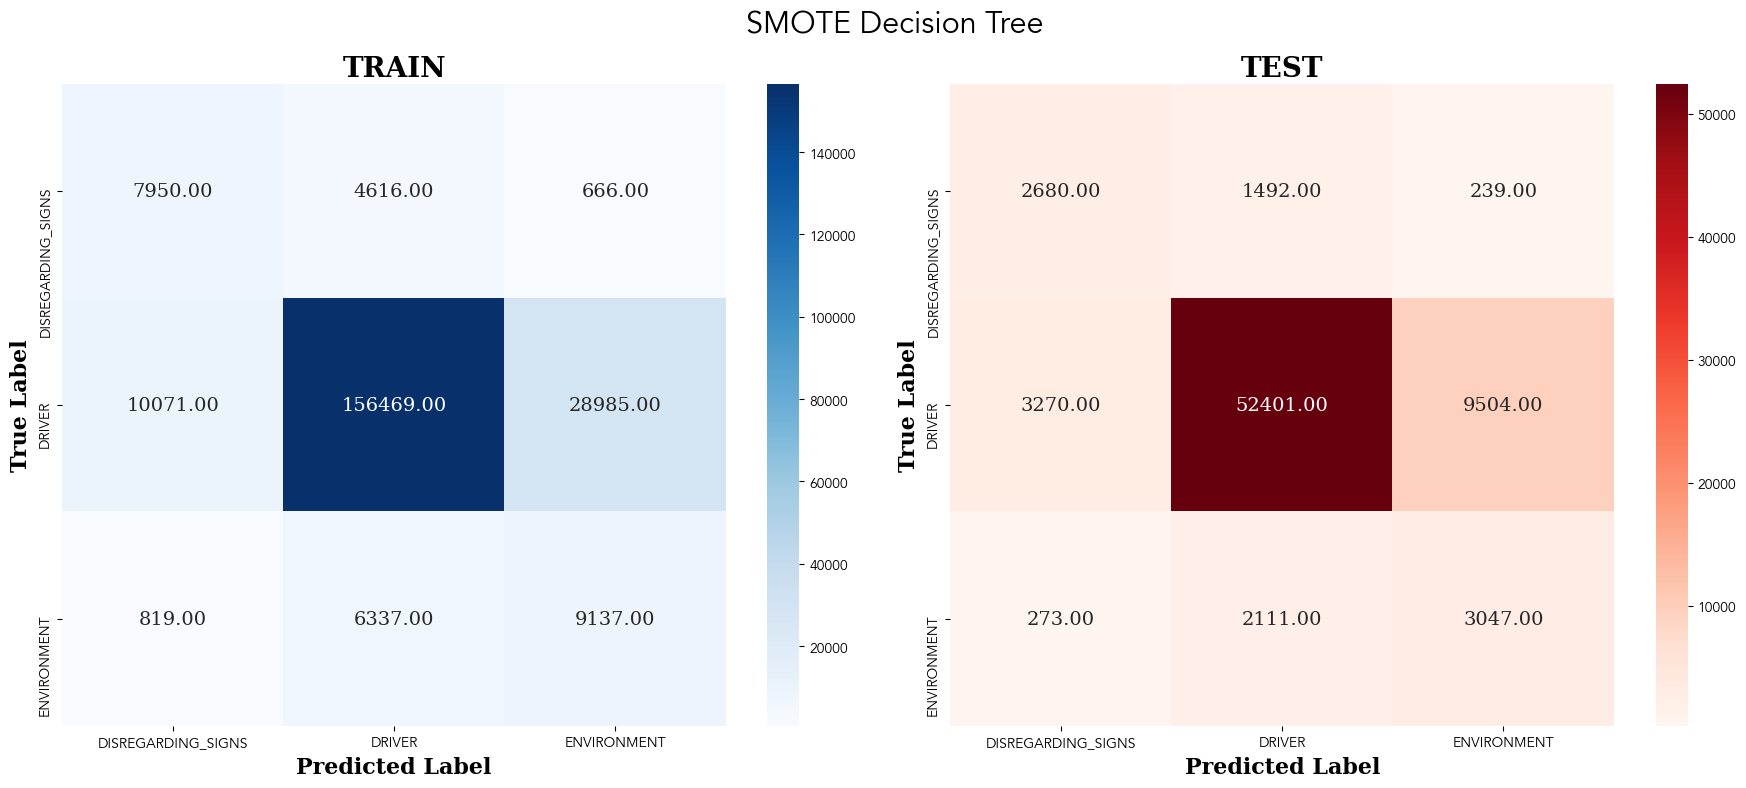

<Figure size 1000x700 with 0 Axes>

In [18]:
decision_tree_smote.confusion_matrices()
plt.savefig('images/gboost_confusion_matrix.png', dpi=150)

## Gradient Boosting Classifier

In [19]:
with open('fitted_models/gradient_boost_smote.pkl', 'rb') as f:
    gradient_boost_fitted = pickle.load(f)

In [20]:
gradient_boost = ModelEvaluator(
    splits,
    gradient_boost_fitted,
    "Gradient Boosting with SMOTE",
    fitted=True
)

print(gradient_boost)

Gradient Boosting with SMOTE: FITTED

Pipeline(steps=[('imputers',
                 ColumnTransformer(transformers=[('binary',
                                                  SimpleImputer(fill_value=False,
                                                                strategy='constant'),
                                                  ['INTERSECTION_RELATED_I',
                                                   'HIT_AND_RUN_I',
                                                   'WORK_ZONE_I']),
                                                 ('categorical',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['TRAFFIC_CONTROL_DEVICE',
                                                   'DEVICE_CONDITION',
                                                   'WEATHER_CONDITION',
                                                   'LIGHTING_CONDITION',
                                           

In [21]:
gradient_boost.train_test_classification_reports()

Predicting Target values...
Target values predicted successfully
__________TRAIN SCORES__________
                    precision    recall  f1-score   support

DISREGARDING_SIGNS       0.51      0.52      0.52     13232
            DRIVER       0.91      0.95      0.93    195525
       ENVIRONMENT       0.57      0.29      0.38     16293

          accuracy                           0.88    225050
         macro avg       0.67      0.59      0.61    225050
      weighted avg       0.87      0.88      0.87    225050

------------------------------

__________TEST SCORES__________
                    precision    recall  f1-score   support

DISREGARDING_SIGNS       0.52      0.52      0.52      4411
            DRIVER       0.91      0.95      0.93     65175
       ENVIRONMENT       0.56      0.29      0.38      5431

          accuracy                           0.88     75017
         macro avg       0.66      0.59      0.61     75017
      weighted avg       0.87      0.88      0.87    

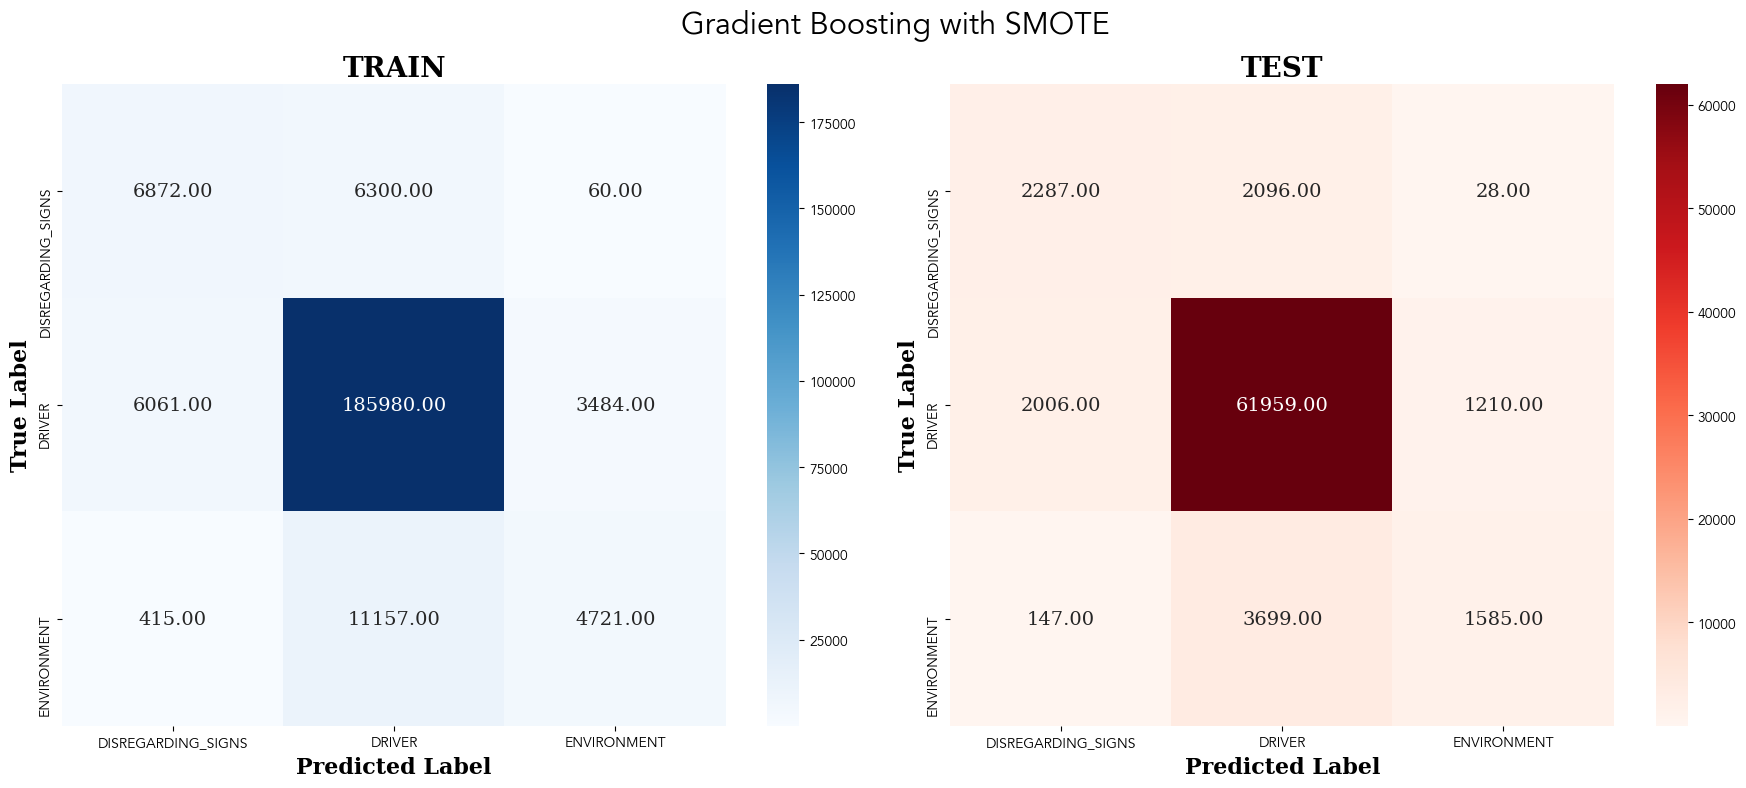

In [22]:
gradient_boost.confusion_matrices()

In [23]:
gradient_boost._fitted_model

Pipeline(steps=[('imputers',
                 ColumnTransformer(transformers=[('binary',
                                                  SimpleImputer(fill_value=False,
                                                                strategy='constant'),
                                                  ['INTERSECTION_RELATED_I',
                                                   'HIT_AND_RUN_I',
                                                   'WORK_ZONE_I']),
                                                 ('categorical',
                                                  SimpleImputer(strategy='most_frequent'),
                                                  ['TRAFFIC_CONTROL_DEVICE',
                                                   'DEVICE_CONDITION',
                                                   'WEATHER_CONDITION',
                                                   'LIGHTING_CONDITION',
                                                   'FIRST_CRASH_TYPE',
          

## Most important features

From the gradient boosting regressor, the most significant features were determined in the following cell through navigating the pipelines contained in the model. Interestingly we found that the one-hot encoded feature from the `FIRST_CRASH_TYPE` column indicating that the first crash was a collision at an angle between two cars (`ANGLE`) was the most significant predictor. This is rather counterintuitive, and only provides more reason to employ more robust measures to handle the original data, given the large amount of categorical features. The other top features are negligible compared to the first in relative terms, and while the weights seem small, this is reflective of the very large number of features present in the final transformed predictor arrays. 

In [24]:
# Get most important features
gboost_steps = gradient_boost._fitted_model.named_steps

feat_importances = gboost_steps['model'].feature_importances_
feat_names = gboost_steps['encoder'].get_feature_names(BIN_FIELDS + CAT_FIELDS + NUM_FIELDS)

pd.Series(feat_importances, index=feat_names).sort_values(ascending=False).head(5)

FIRST_CRASH_TYPE_ANGLE                0.294219
TRAFFIC_CONTROL_DEVICE_NO CONTROLS    0.085657
ROADWAY_SURFACE_COND_DRY              0.071506
NUM_UNITS_1.0                         0.059899
FIRST_CRASH_TYPE_TURNING              0.052566
dtype: float64

## Conclusions and Future Expansion Ideas
For the business problem at hand, i.e. reducing the occurence of car crashes resulting in fatal or incapacitating injuries in Chicago, the most useful recommendations came from the initial exploratory analysis, while the models serve as a starting point for creating a tool that could greatly improve the data available in the Chicago Data Portal. In the future, this project could be greatly expanded by: 

* Merging all three datasets to increase the data diversity
* Utilizing unsupervised learning techniques to identify geographical clusters where fatal and injury-causing crashes are more likely to occur
* Redefining the class groupings in order to segment off the majority class, i.e. `DRIVER`
* Performing extensive hyperparameter tuning on models and using a greater variety of models, including custom ensemble techniques.